# SENTIMENT ANALYSIS BY BERT AND AMAZON DATA SET
The present assessment was developed with the reference code and guide Youtube video Análisis de sentimientos con BERT en Python (Tutorial) by codificandobits and the notebook Getting-Things-Done-with-Pytorch/08.sentiment-analysis-with-bert.ipynb by curiousily

The assessment was developed by Dario Chicaiza 00321774T, Jahnavi Choragudi A00042212, and Edwin Camacho A00034927

**Setup** 
Transformers is the necessary library to work with BERT

In [ ]:
  !pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 42.6 MB/s 
     |████████████████████████████████| 895 kB 43.7 MB/s 
     |████████████████████████████████| 596 kB 44.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import pickle
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

#Libraries to create graphs
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import torch.nn.functional as F

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Initialization 
RANDOM_SEED = 42 #
MAX_LEN = 200 # Text review size
BATCH_SIZE = 16
NCLASSES = 2 # because there are two type of labels: positive sentiment and negative sentiment. BERT learns to identify pos and neg comments

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Data Preparation**

In [ ]:
# sorted_data_acl with all reviews file must be loaded in you own google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Parse xml file
def Processing_XML_Reviews_Dictionnaire(ListReviews):
    count = 0
    Review = []
    Reviews = {}
    for i in range(len(ListReviews)):
        if ListReviews[i] != '</review>\n':
            if ListReviews[i] == '<review>\n' and ListReviews[i+1] == '<unique_id>\n':
                # unique_id
                Review.append('unique_id/'+ListReviews[i+2])
            #if ListReviews[i] == '</unique_id>\n' and ListReviews[i+1] == '<unique_id>\n':
                #unique_idN
                #Review.append('unique_id/'+ListReviews[i+2])
            if  ListReviews[i] == '<asin>\n':
                #asin
                Review.append('asin/'+ListReviews[i+1])    
            if  ListReviews[i] == '<product_name>\n':
                #productName
                Review.append('product_name/'+ListReviews[i+1])
            #if  ListReviews[i] == '</product_type>\n' and ListReviews[i+1] == '<product_type>\n' :
                #here we append the producttype
                #Review.append('product_type/'+ListReviews[i+2])
            if ListReviews[i] == '<helpful>\n':
                #helpful
                Review.append('helpful/'+ListReviews[i+1])
            if ListReviews[i] == '<rating>\n':
                Review.append('rating/'+ListReviews[i+1])
            if ListReviews[i] == '<title>\n':
                Review.append('title/'+ListReviews[i+1])
            if ListReviews[i] == '<date>\n':
                Review.append('date/'+ListReviews[i+1])
            if ListReviews[i] == '<reviewer>\n':
                Review.append('reviewer/'+ListReviews[i+1])
            if ListReviews[i] == '<reviewer_location>\n':
                Review.append('reviewer_location/'+ListReviews[i+1])
            if ListReviews[i] == '<review_text>\n':
                Review.append('review_text/'+ListReviews[i+1])
        elif ListReviews[i] == '</review>\n':
            count = count + 1
            r = 'review'+ str(count) 
            Reviews[r] = Review
            #nfargou list
            Review = []
    return Reviews

In [ ]:
##Convert reviews from Dictionary to pandas dataframe
def Porcessing_Dictonnary_ToDataFrame(Dict):
    #on prepare notre dataframe pour les données
    df = pd.DataFrame(columns=['unique_id','asin','product_name','helpful','rating','title',
                    'date','reviewer','reviewer_location','review_text'])
    count = 0
    for i,k in Dict.items():
        df.loc[count] = [k[0].split("/")[1].split("\n")[0],k[1].split("/")[1].split("\n")[0]
                              ,k[2].split("/")[1].split("\n")[0],k[3].split("/")[1].split("\n")[0]
                              ,k[4].split("/")[1].split("\n")[0],k[5].split("/")[1].split("\n")[0]
                              ,k[6].split("/")[1].split("\n")[0],k[7].split("/")[1].split("\n")[0]
                              ,k[8].split("/")[1].split("\n")[0],k[9].split("/")[1].split("\n")[0]
        ]
        count = count + 1

    return df

In [23]:
## Raw dataset obtained from the following colab notebook
!git clone https://github.com/avinashsai/Cross-domain-sentiment-analysis.git

Cloning into 'Cross-domain-sentiment-analysis'...
remote: Enumerating objects: 196, done.
remote: Total 196 (delta 0), reused 0 (delta 0), pack-reused 196
Receiving objects: 100% (196/196), 5.38 MiB | 14.43 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [24]:
## Bring the data of the 4 type of products within the dataset into 2 dictionaries
import os
indir = '/content/Cross-domain-sentiment-analysis/Dataset/sorted_data_acl' 
PositifReviews = []
NegativeReviews = []
for root, dirs, filenames in os.walk(indir):
    for f in filenames:
        if f == "positive.review":
            log = open(os.path.join(root, f), 'r').readlines()
            PositifReviews.append(Processing_XML_Reviews_Dictionnaire(log))
            print(os.path.join(root, f))
        if f == "negative.review":
            log = open(os.path.join(root, f), 'r').readlines()
            NegativeReviews.append(Processing_XML_Reviews_Dictionnaire(log))
            print(os.path.join(root, f))

/content/Cross-domain-sentiment-analysis/Dataset/sorted_data_acl/books/positive.review
/content/Cross-domain-sentiment-analysis/Dataset/sorted_data_acl/books/negative.review
/content/Cross-domain-sentiment-analysis/Dataset/sorted_data_acl/dvd/positive.review
/content/Cross-domain-sentiment-analysis/Dataset/sorted_data_acl/dvd/negative.review
/content/Cross-domain-sentiment-analysis/Dataset/sorted_data_acl/kitchen_and_housewares/positive.review
/content/Cross-domain-sentiment-analysis/Dataset/sorted_data_acl/kitchen_and_housewares/negative.review
/content/Cross-domain-sentiment-analysis/Dataset/sorted_data_acl/electronics/positive.review
/content/Cross-domain-sentiment-analysis/Dataset/sorted_data_acl/electronics/negative.review


In [25]:
## datasets sorted by positive and negative
df_Postive_Rev = pd.DataFrame(columns=['unique_id','asin','product_name','helpful','rating','title',
                    'date','reviewer','reviewer_location','review_text'])
df_Negative_Rev = pd.DataFrame(columns=['unique_id','asin','product_name','helpful','rating','title',
                    'date','reviewer','reviewer_location','review_text'])
df = pd.DataFrame()

for Rev in PositifReviews:
    df = Porcessing_Dictonnary_ToDataFrame(Rev)
    df_Postive_Rev = pd.concat([df_Postive_Rev, df])
    df.empty

df1 = pd.DataFrame()
for Rev in NegativeReviews:
    df1 = Porcessing_Dictonnary_ToDataFrame(Rev)
    df_Negative_Rev = pd.concat([df_Negative_Rev, df1])
    df1.empty

In [26]:
df.shape

(1000, 10)

In [27]:
## Concatenate the data in 1 file
df_Postive_Rev['Class'] = "pos" # review positives
df_Negative_Rev['Class'] = "neg" #review Negatif
Reviews  = pd.concat([df_Postive_Rev,df_Negative_Rev])
Reviews.drop('unique_id',axis=1,inplace=True)  ## Unique_id Has the same information as "asin" "title" "reviewer" so it could be eliminated
test_Revs = pd.DataFrame(Reviews)

In [28]:
test_Revs.shape

(8000, 10)

In [ ]:
## Count number of words in the text_review column
def identify_tokens(row):
    
    Clean_reviews = row['review_text']
    tokens = nltk.word_tokenize(Clean_reviews)
    # taken only words and numbers (not punctuation)
    token_words = [w for w in tokens if w.isalnum()]
    return token_words

test_Revs['words'] = test_Revs.apply(identify_tokens, axis=1)


## Count words per row
def total_elements(row):
  words = row['words']
  count = 0
  for element in words:
      count += 1
  return count

test_Revs['num_words'] = test_Revs.apply(total_elements, axis=1)

In [ ]:
# Delete null or short word row indexes from dataFrame
indexNames = test_Revs[test_Revs['num_words'] <= 1 ].index
test_Revs.drop(indexNames , inplace=True)

In [ ]:
test_Revs.columns

Index(['asin', 'product_name', 'helpful', 'rating', 'title', 'date',
       'reviewer', 'reviewer_location', 'review_text', 'Class', 'words',
       'num_words'],
      dtype='object')

In [ ]:
df=test_Revs

In [ ]:
df.columns

Index(['asin', 'product_name', 'helpful', 'rating', 'title', 'date',
       'reviewer', 'reviewer_location', 'review_text', 'Class', 'words',
       'num_words'],
      dtype='object')

In [ ]:
#Clean and crop columms we are not going to use
df.drop(['asin', 'product_name', 'helpful', 'rating', 'title', 'date',
       'reviewer', 'reviewer_location', 'words',
       'num_words'],axis=1,inplace=True)
df.rename(columns={'Class':'sentiment','review_text':'review'},
               inplace=True)
df

,review,sentiment
1,Dr. Oz is an accomplished heart surgeon in the...,pos
2,The most gorgeous artwork in comic books. Cont...,pos
3,This book is for lovers of Robicheaux. His de...,pos
5,"Since I am a World's Fair ""fanatic"" I have rea...",pos
6,This the one book that taught me more about ho...,pos
...,...,...
995,This thermometer lasted about a month before g...,neg
996,"Bought my first Vornado years ago, and is the ...",neg
997,More money then its worth. Makes alot of nois...,neg
998,Mine broke on the 3rd use! No need to say any...,neg


In [ ]:
test_Revs.to_csv('reviewsFull.csv')

In [ ]:
df=pd.read_csv('reviewsFull.csv')
print(df.shape)

(7432, 3)


In [ ]:
# Re-setup dataset
df['label'] = (df['sentiment']=='pos').astype(int)
df.drop('sentiment', axis=1, inplace=True)
df.head()

,Unnamed: 0,review,label
0,1,If you don't own this dvd you need to add it t...,1
1,2,Denzel Washington is great but Angelina Jolie ...,1
2,3,I rediscovered this after a long time. This is...,1
3,5,R.J. The Raccoon (Bruce Willis) was just looki...,1
4,6,9 to 5 was the first film to address the glass...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


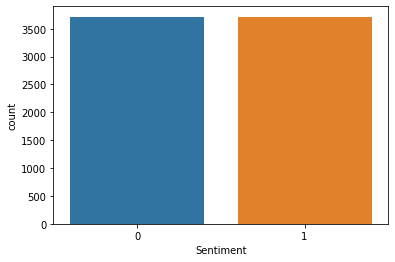

In [ ]:
# How balanced is the dataframe between pos(1) and negative(0) reviews
sns.countplot(df.label)
plt.xlabel('Sentiment');

**TOKENIZATION**

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

**DATA SET CREATION**

In [ ]:
# Class to create DATA SET

class IMDBDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.reviews)
   # get ramdonly data (batchsize)  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )
    #get back a dictionary

    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      } 

In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = IMDBDataset(
      reviews = df.review.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

**SPLIT DATA TRAIN AND DATA TEST**

In [ ]:
df_train, df_test = train_test_split(df,test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**MODELING BERT CLASS AND FINE-TUNED THE PRE-TRAINED BERT MODEL**

In [ ]:
# Class to Model the BERT and fine-tuning adding the last custom layer to retrain the pre-trained BERT Model with our Amazon dataset

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
    # Reduce and improve overfitting. Train data and test data generate a similar accuracy
    self.drop = nn.Dropout(p=0.3)
    #hidden size 768 BERT model
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
    

  
  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert( #cls_output = clasificate token
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

In [ ]:
# Initialize BERT Class
model = BERTSentimentClassifier(NCLASSES)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**TRAINING**

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function to train the model

def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    #back propagation
    loss.backward()
    # Avoid the gradient encreases too much and train stalls
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

# Function to eval the model

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
# Run training iteration according the given epochs

history = defaultdict(list)
for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Training: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Evaluation: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)
  
  

# save the model to disk
filename = 'TrainedModelCPU1_bert_.sav'
pickle.dump(model, open(filename, 'wb'))

Epoch 1 de 3
------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training: Loss: 0.4708328002923599, accuracy: 0.7867115222876366
Evaluation: Loss: 0.340288369806223, accuracy: 0.855413584398117

Epoch 2 de 3
------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training: Loss: 0.2325734636215593, accuracy: 0.9160639192598822
Evaluation: Loss: 0.4889638417510576, accuracy: 0.8433086751849361

Epoch 3 de 3
------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training: Loss: 0.12545223252832768, accuracy: 0.9648444070647603
Evaluation: Loss: 0.5492092568267096, accuracy: 0.8614660390047074



**GRAPH THE OUTCOMES**

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

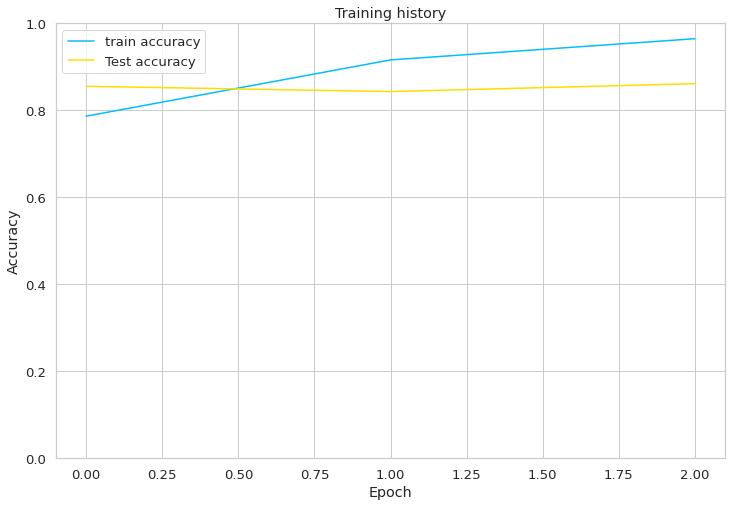

In [ ]:
#Graph the Train accuracy Vs. Test accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='Test accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)
class_names = ['negative', 'positive']

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

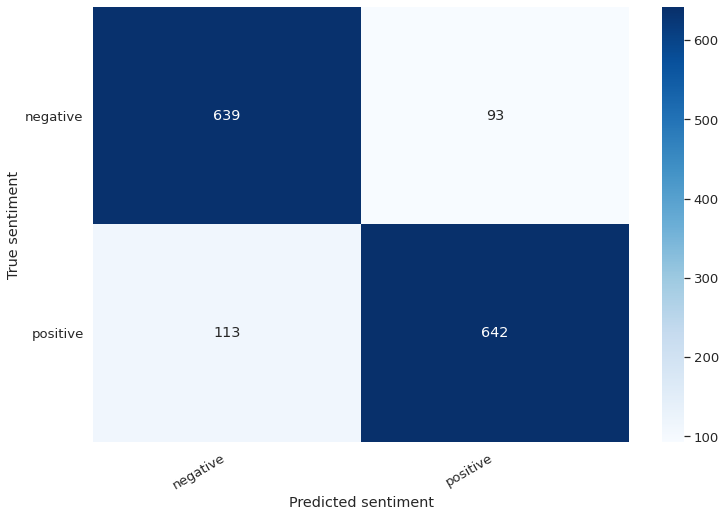

In [ ]:
#Graph confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

**TEST THE MODEL**

In [ ]:
def classifySentiment(review_text,model):
  encoding_review = tokenizer.encode_plus(
      review_text,
      max_length = MAX_LEN,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
      )
  
  input_ids = encoding_review['input_ids'].to(device)
  attention_mask = encoding_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  print("\n".join(wrap(review_text)))
  if prediction:
    print('Sentiment: Positive')
  else:
    print('Sentiment: Negative')

In [ ]:
review_text = "I'm not sure why Sony, which now owns I Dream of Jeannie, decided to colorize the first season of this series.  Whatever the reason, you can readily tell by looking at the prices here on Amazon.com that the original black-and-white version of the first season is worth a lot more.  The reason for that is simple--I Dream of Jeannie was originally broadcast in black-and-white.  And for a television fan like myself, that's the ONLY way to watch the first season."

classifySentiment(review_text,model)

I'm not sure why Sony, which now owns I Dream of Jeannie, decided to
colorize the first season of this series.  Whatever the reason, you
can readily tell by looking at the prices here on Amazon.com that the
original black-and-white version of the first season is worth a lot
more.  The reason for that is simple--I Dream of Jeannie was
originally broadcast in black-and-white.  And for a television fan
like myself, that's the ONLY way to watch the first season.
Sentiment: Positive


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
